100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


tensor([[249,  61],
        [ 64, 226]])
Best threshold: 0.4808867275714874
APCER: 0.1967741996049881
BPCER: 0.22068965435028076
ACER: 0.20873191952705383


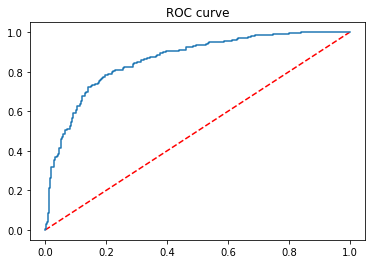

AUC: 0.8608899


In [47]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam
from src.core.trainer import Trainer
from src.utils.data import ParallelInfiniteDataLoader
from src.dataset import StandardDataset, CombinedDataset
from src.core.config import Config
from src.core.model_config import ModelConfig
from src.network import Model, TestModel
from src.utils.optimizer import SophiaG
from src.utils.callbacks import ModelCheckpoint
from src.utils.layers import Conv2d, LDConv2d, CDConv2d
from src.utils.transform import *
import torchvision.transforms as t

import random
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(Config.SEED + 256) ## Give different data during validating in training
random.seed(Config.SEED + 256)
np.random.seed(Config.SEED + 256)




CHECKPOINT_PATH = r'validation_weight\MetaSGD_tpl_model_epoch=18800_epoch_acc=0.7783_best_k=1.pth'

ModelConfig.IN_CHANNELS = 3
model = TestModel(ModelConfig, conv_type = LDConv2d)
ckpt = torch.load(CHECKPOINT_PATH, map_location= 'cpu')
model.load_state_dict(ckpt["model_checkpoint"])
model = model.cuda()
model.eval();

train_data_settings = {'get_real': None, 
                       'get_hsv': False if ModelConfig.IN_CHANNELS == 3 else True}
ds3 = StandardDataset('data/zalo_data', transform = t.Compose([ToTensor()]), **train_data_settings)

# smplr3 = WeightedRandomSampler(ds3.get_weight(), len(ds3))
# dl3 = DataLoader(ds3, batch_size= Config.BATCH_SIZE, sampler = smplr3)

weight = np.array(ds3.get_weight())
weight /= weight.sum()
indices_list = np.random.choice(list(range(len(ds3))), Config.BATCH_SIZE * 100, False,weight)
ds3 = torch.utils.data.Subset(ds3, indices_list)
dl3 = DataLoader(ds3, batch_size= Config.BATCH_SIZE)

pred = []
target = []

feat = []

with torch.no_grad():
    for idx, batch in enumerate(tqdm(dl3)):
        img, map_gt, label_gt = batch[0].float().cuda(), batch[1].float().cuda(), batch[2].float().cuda()

        cls_pr, feat_pr = model(img)

        label_pr = torch.softmax(cls_pr, dim=1)

        feat.append(feat_pr.cpu())
        pred.append(label_pr)
        target.append(label_gt)

pred = torch.cat(pred, dim = 0).tolist()
pred = torch.tensor(list(zip(*pred))[1])

target = torch.cat(target, dim= 0).cpu()

feat = torch.cat(feat, dim = 0)

from torchmetrics.functional.classification import binary_confusion_matrix
from torchmetrics.functional.classification import binary_roc
import matplotlib.pyplot as plt

roc = binary_roc(pred, target, thresholds = None)
fpr, tpr, threshold = roc[0].cpu(), roc[1].cpu(), roc[2].cpu()



best_threshold = threshold[np.argmin((((1 - tpr)+fpr)/2).numpy())]

confusion_matrix = binary_confusion_matrix(pred, target, threshold= best_threshold.item())
# confusion_matrix = binary_confusion_matrix(pred, target, threshold= 0.519)

print(confusion_matrix)

tn, fp, fn, tp = confusion_matrix[0,0], confusion_matrix[0,1], confusion_matrix[1,0], confusion_matrix[1,1]

apcer = fp/(tn+fp)
bpcer = fn/(tp+fn)
acer= (apcer+bpcer)/2
print("Best threshold:",best_threshold.item())
print("APCER:",apcer.item())
print("BPCER:",bpcer.item())
print("ACER:",acer.item())




plt.plot(fpr,fpr, 'r--')
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.show()

def get_once_diff(arr):
    X = np.asarray(arr)[1:]
    X_lag = np.roll(arr,1)[1:]
    return X-X_lag

print("AUC:",np.sum(get_once_diff(fpr)*(np.asarray(tpr)[1:]+np.asarray(tpr)[:-1])/2))

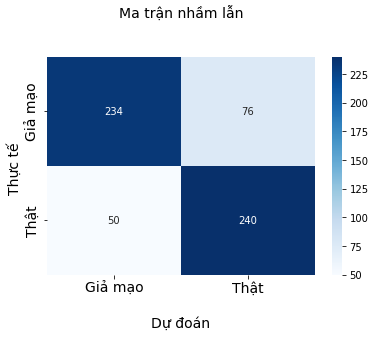

In [34]:
import seaborn as sns

FONTSIZE = 14

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt= "")

ax.set_title('Ma trận nhầm lẫn\n\n', fontsize = FONTSIZE);
ax.set_xlabel('\nDự đoán', fontsize = FONTSIZE)
ax.set_ylabel('Thực tế ', fontsize = FONTSIZE);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Giả mạo','Thật'], fontsize = FONTSIZE)
ax.yaxis.set_ticklabels(['Giả mạo','Thật'], fontsize = FONTSIZE)

## Display the visualization of the Confusion Matrix.
plt.show()

In [29]:
# base_fpr, base_tpr
# maml_fpr, maml_tpr
# meta_fpr, meta_tpr
# maml_tpl_fpr, maml_tpl_tpr
# meta_tpl_fpr, meta_tpl_tpr

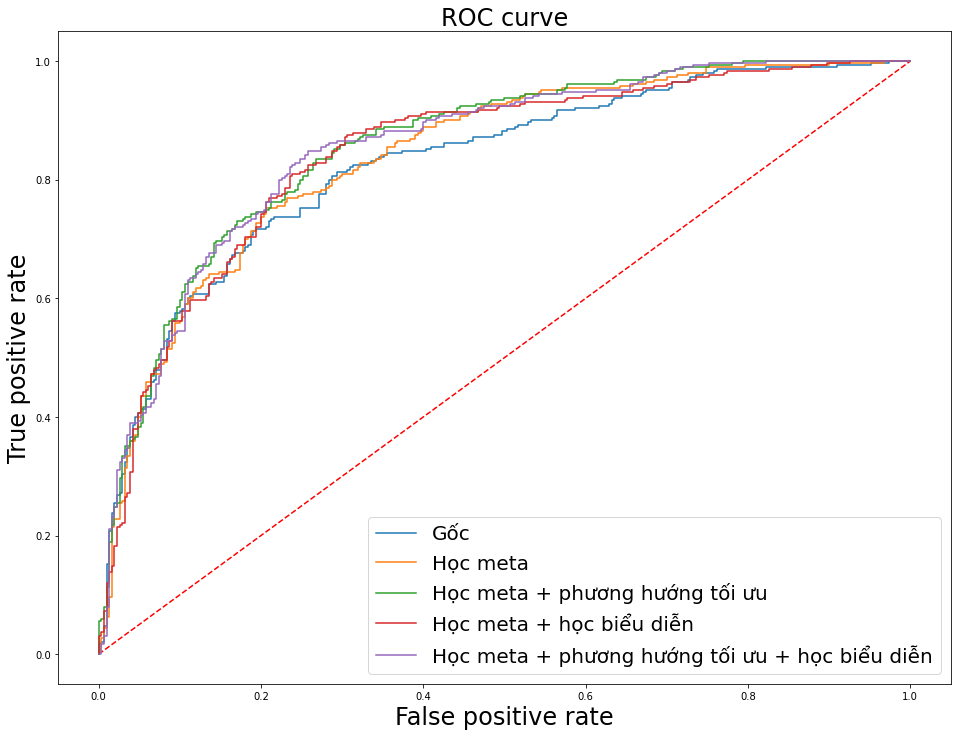

In [32]:
plt.figure(figsize = (16,12))

plt.plot(fpr,fpr, 'r--')
plt.plot(base_fpr,base_tpr, label = 'Gốc')

plt.plot(maml_fpr,maml_tpr, label = 'Học meta')

plt.plot(meta_fpr,meta_tpr, label = 'Học meta + phương hướng tối ưu')

plt.plot(maml_tpl_fpr,maml_tpl_tpr, label = 'Học meta + học biểu diễn')

plt.plot(meta_tpl_fpr,meta_tpl_tpr, label = 'Học meta + phương hướng tối ưu + học biểu diễn')
plt.legend(fontsize = 20)
plt.xlabel("False positive rate", fontsize = 24)
plt.ylabel("True positive rate", fontsize = 24)
plt.title('ROC curve', fontsize = 24)
plt.show()

In [4]:
#  tsne_torch.py
#
# Implementation of t-SNE in pytorch. The implementation was tested on pytorch
# > 1.0, and it requires Numpy to read files. In order to plot the results,
# a working installation of matplotlib is required.
#
#
# The example can be run by executing: `python tsne_torch.py`
#
#
#  Created by Xiao Li on 23-03-2020.
#  Copyright (c) 2020. All rights reserved.
import numpy as np
import matplotlib.pyplot as plt
import torch


# if opt.cuda:
#     print("set use cuda")
#     torch.set_default_tensor_type(torch.cuda.DoubleTensor)
# else:
#     torch.set_default_tensor_type(torch.DoubleTensor)


def Hbeta_torch(D, beta=1.0):
    P = torch.exp(-D.clone() * beta)

    sumP = torch.sum(P)

    H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
    P = P / sumP

    return H, P


def x2p_torch(X, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape

    sum_X = torch.sum(X*X, 1)
    D = torch.add(torch.add(-2 * torch.mm(X, X.t()), sum_X).t(), sum_X)

    P = torch.zeros(n, n)
    beta = torch.ones(n, 1)
    logU = torch.log(torch.tensor([perplexity]))
    n_list = [i for i in range(n)]

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        # there may be something wrong with this setting None
        betamin = None
        betamax = None
        Di = D[i, n_list[0:i]+n_list[i+1:n]]

        (H, thisP) = Hbeta_torch(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while torch.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].clone()
                if betamax is None:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].clone()
                if betamin is None:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta_torch(Di, beta[i])

            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, n_list[0:i]+n_list[i+1:n]] = thisP

    # Return final P-matrix
    return P


def pca_torch(X, no_dims=50):
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - torch.mean(X, 0)

    (l, M) = torch.eig(torch.mm(X.t(), X), True)
    # split M real
    # this part may be some difference for complex eigenvalue
    # but complex eignevalue is meanless here, so they are replaced by their real part
    i = 0
    while i < d:
        if l[i, 1] != 0:
            M[:, i+1] = M[:, i]
            i += 2
        else:
            i += 1

    Y = torch.mm(X, M[:, 0:no_dims])
    return Y


def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should not have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca_torch(X, initial_dims)
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = torch.randn(n, no_dims)
    dY = torch.zeros(n, no_dims)
    iY = torch.zeros(n, no_dims)
    gains = torch.ones(n, no_dims)

    # Compute P-values
    P = x2p_torch(X, 1e-5, perplexity)
    P = P + P.t()
    P = P / torch.sum(P)
    P = P * 4.    # early exaggeration
    print("get P shape", P.shape)
    P = torch.max(P, torch.tensor([1e-21]))

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = torch.sum(Y*Y, 1)
        num = -2. * torch.mm(Y, Y.t())
        num = 1. / (1. + torch.add(torch.add(num, sum_Y).t(), sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / torch.sum(num)
        Q = torch.max(Q, torch.tensor([1e-12]))

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = torch.sum((PQ[:, i] * num[:, i]).repeat(no_dims, 1).t() * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)).double() + (gains * 0.8) * ((dY > 0.) == (iY > 0.)).double()
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - torch.mean(Y, 0)

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = torch.sum(P * torch.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


    # X1 = torch.randn([10, 2048]).cuda()
    # # no_dims=2, initial_dims=50, perplexity=30.0
    # X_emb = tsne(X1, no_dims=2, perplexity=100., initial_dims=50)


In [5]:
pred_tsne = tsne(feat)

Preprocessing the data using PCA...


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 618475290624 bytes.